# Calibration Example

Import modules

In [1]:
import numpy as np
from scipy.optimize import fmin

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

Set global parameters

In [2]:
#Contract Parameters
S0 = 100
K = 80
k = np.log(K)
r = 0.05
q = 0.015

# Parameters
alpha = 1.5
eta = 0.2

n = 12
N = 2**n
# step-size in log strike space
lda = (2*np.pi/N)/eta

#Choice of beta
beta = np.log(S0)-N*lda/2
#beta = np.log(K)

# Model
model = 'Heston'

kappa = 2.75
theta = 0.0625
sig = 0.25
rho = -0.65
v0 = 0.05

params = []
params.append(kappa)
params.append(theta)
params.append(sig)
params.append(rho)
params.append(v0)

#model = 'VG'
#sig = 0.25
#nu = 0.4
#theta = -0.3

#params = []
#params.append(sig)
#params.append(nu)
#params.append(theta)

Define functions

In [3]:
#Generating Option Price Surface Under A model from the list         
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0);
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));

    return phi

def genericFFT(params, T):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km

def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment

def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

Run example

In [4]:
lenK = 11
lenT = 13

strikes = 70. + 5. * np.arange(lenK)
maturities = 0.2 + 0.05 * np.arange(lenT)

marketPrices = np.zeros((lenK, lenT))

for i in range(lenT):
    T = maturities[i]
    [km, cT_km] = genericFFT(params, T)
    marketPrices[:,i] = np.interp(np.log(strikes), km, cT_km)

Plot

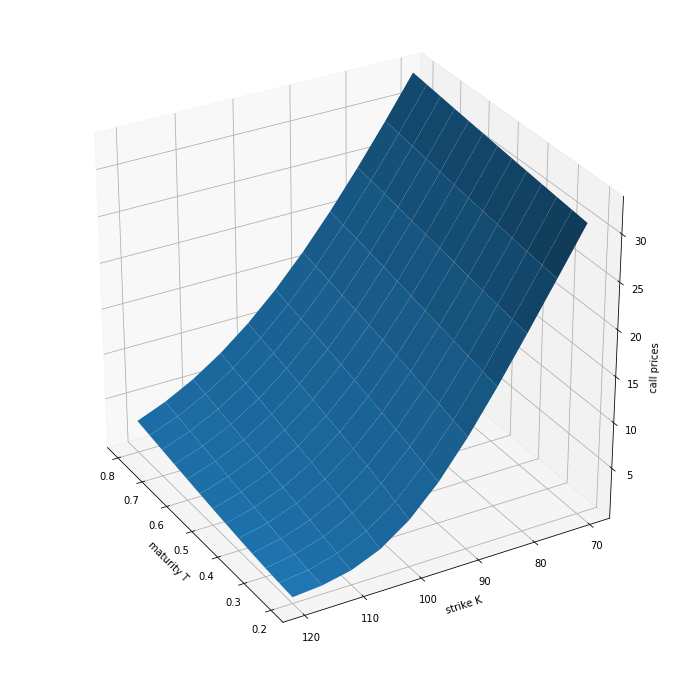

In [5]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(maturities, strikes)
ax.plot_surface(X, Y, marketPrices)
ax.set_xlabel('maturity T')
ax.set_ylabel('strike K')
ax.set_zlabel('call prices')
ax.view_init(30, 150)
plt.show()

Perform a grid search and find the optimal parameters

In [7]:
modelPrices = np.zeros((lenK, lenT))

maeMin = 1.0e6
for kappa in myRange(2.5,3.0,0.25):
    for theta in myRange(0.06,0.065,0.0025):
        for sig in myRange(0.1,0.3,0.05):
            for rho in myRange(-0.675,-0.625,0.025):
                for v0 in myRange(0.04,0.06,0.01):
                    tmp_params = []
                    tmp_params.append(kappa)
                    tmp_params.append(theta)
                    tmp_params.append(sig)
                    tmp_params.append(rho)
                    tmp_params.append(v0)
                    mae = 0;
                    for j in range(lenT):
                        T = maturities[j]
                        #print tmp_params, T
                        [km, cT_km] = genericFFT(tmp_params, T)
                        modelPrices[:,j] = np.interp(np.log(strikes), km, cT_km)
                        tmp = marketPrices[:,j]-modelPrices[:,j]
                        mae += np.sum(np.multiply(tmp, tmp))

                    if (mae < maeMin):
                        maeMin = mae
                        params2 = tmp_params

print(params2)

[2.75, 0.0625, 0.25, -0.65, 0.05]
